In [767]:
from cmath import inf
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sympy as sy
from sympy import *
import math
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [768]:
### warnings ###
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)                                                                                           

### symbols ###
x = Symbol('x')

In [769]:
class ClassRoots:
    def __init__(self):
        pass

    def rootsearch(self,f,a,b,dx):
        x1 = a; f1 = f(a)
        x2 = a + dx; f2 = f(x2)
        while f1*f2 > 0.0:
            if x1 >= b:
                return None,None
            x1 = x2; f1 = f2
            x2 = x1 + dx; f2 = f(x2)
        return x1,x2

    def bisect(self, f,x1,x2,switch=0,epsilon=1.0e-9):
        f1 = f(x1)
        if f1 == 0.0:
            return x1
        f2 = f(x2)
        if f2 == 0.0:
            return x2
        if f1*f2 > 0.0:
            #print('Root is not bracketed')
            return None
        n = int(math.ceil(math.log(abs(x2 - x1)/epsilon)/math.log(2.0)))
        for i in range(n):
            x3 = 0.5*(x1 + x2); f3 = f(x3)
            if (switch == 1) and (abs(f3) >abs(f1)) and (abs(f3) > abs(f2)):
                return None
            if f3 == 0.0:
                return x3
            if f2*f3 < 0.0:
                x1 = x3
                f1 = f3
            else:
                x2 =x3
                f2 = f3
        return (x1 + x2)/2.0

    def roots(self,f, a, b, eps=1e-6):
        #print ('The roots on the interval [%f, %f] are:' % (a,b))
        zeros = []
        while 1:
            x1,x2 = self.rootsearch(f,a,b,eps)
            if x1 != None:
                a = x2
                root = self.bisect(f,x1,x2,1)
                if root != None:
                    pass
                    #print (round(root,-int(math.log(eps, 10))))
                    zeros.append(round(root,-int(math.log(eps, 10))))
            else:
                #print(zeros)
                #print ('\nDone')
                break
        return zeros

In [770]:
### methods ###

def g():
    """Example function for inital surface"""
    return -abs(x)

def transformer_function(values, func, xshift):
    """
    Transforms expression of a function into a numpy expression and returns a parametrization

    values: values of x-coordinate
    func: function that is transformed into a numpy expression
    xshift: shift of x-coordinates
    """
    npFunc = lambdify(x, func, 'numpy')
    return values + xshift, npFunc(values)

def transformer_vector(values, vector):
    """
    Transforms expression of a function into a numpy expression
    
    Caution: This does not always work, e.g. for abs(x).
    """
    npFunc0 = lambdify(x, vector[0], 'numpy')
    npFunc1 = lambdify(x, vector[1], 'numpy')
    return npFunc0(values), npFunc1(values)

def normal_vector(func):
    """
    Calculates normal vector of simply parametrized function.
    
    Simply parametrized here means, that it is of the form (x, f(x))
    """
    funcPrime = func.diff(x)
    return -funcPrime, 1

def minkowski_normal_vector(func):
    funcPrime = func.diff(x)
    return funcPrime, 1

def normal_of_segment(x):
    """
    Return tangent vector of a two line segments

    x: list of values
    """
    u = []
    v = []
    for i in range(len(x)):
        if x[i] > 0:
            u.append(1 / np.sqrt(2))
            v.append(1/ np.sqrt(2))
        else: 
            u.append(-1 / np.sqrt(2))
            v.append(1 / np.sqrt(2))
    return u,v 

def normic(values, func):
    return unit_vector(transformer_vector(values, normal_vector(func)))

def minkowski_normic(values, func):
    return minkowski_unit_vector(transformer_vector(values, minkowski_normal_vector(func)))

def unit_vector(vector):
    """Returns the unit vector of the vector"""
    return vector[0] / norm(vector), vector[1] / norm(vector)

def minkowski_unit_vector(vector):
    norm = minkowski_norm(vector)
    return vector[0] / norm, vector[1] / norm

def norm(vector):
    return np.sqrt(vector[0]**2 + vector[1]**2)

def minkowski_norm(vector):
    radicand = vector[1]**2 - vector[0]**2
    return np.sqrt(radicand)

def inner_product2D(v, w):
    """
    Calculates the scalar product of two 2 dimensional vectors
     
    v: list of two floats representing x and y coordinate
    w: list of two floats representing x and y coordinate
    """
    return v[0] * w[0] + v[1] * w[1]

def angle_between_vectors(v,w):
    """Returns angle between two 2D vectors"""
    return np.arccos(inner_product2D(v / np.linalg.norm(v), w / np.linalg.norm(w)))

def unitCircle(t, center):
    """
    Draw a unit circle around a point

    t: list of parameters
    a: point at which the unit circle is drawn
    """
    return center[0] + np.cos(t), center[1] + np.sin(t)

def circle(t, center, radius):
    """Returns circle with given radius centered around a given point"""
    x = center[0] + np.cos(t) * radius
    y = center[1] + np.sin(t) * radius
    return x, y 

def curvature(func):
    """Calculates curvature of initial surface"""
    funcPrime = func.diff()
    func2Prime = func.diff()
    k = func2Prime / (1 + funcPrime**2)**(3 / 2)
    return k

def osculating_circle(point, func):
    """Calculates the osculating circle of a function"""
    px, py = point
    # function and its derivatives
    funcPrime = func.diff()
    func2Prime = funcPrime.diff()
    # function and its derivatives into numpy
    npFuncPrime = lambdify(x, funcPrime, 'numpy')
    npFunc2Prime = lambdify(x, func2Prime, 'numpy')
    # calculate radius of oculating circle
    if npFunc2Prime(px) == 0: return 0,0,0
    else:
        r = np.abs(((1 + npFuncPrime(px) ** 2) ** (3 / 2)) / npFunc2Prime(px))
        # calculate center of osculating circle
        kx = px - (npFuncPrime(px)*(1 + npFuncPrime(px)**2)) / npFunc2Prime(px)
        ky = py + (1 + npFuncPrime(px)**2) / npFunc2Prime(px)
        #plt.plot(kx, ky, 'ro')
    return r, kx, ky

def find_duplicates(list):
    """Returns duplicates in a given list"""
    seen = set()
    uniq = []
    duplicates = []
    for x in list:
        if x not in seen:
            uniq.append(x)
            seen.add(x)
        else:
            duplicates.append(x)
    return duplicates

def kink_position():
    return 3 * np.pi / 2

def index_normal_sign_flip(surface):
    """ 
    Returns entry of x coordinate where the sign flip of the normal vectors appears

    surface: tupel of x and y coordinates, 
             the future surface consists of the points where the normal vectors end, 
             if a sign flip in the x-coordinate happens, then the normal vectors flipped
             direction
    """
    for i in range(len(surface[0])):
        if surface[0][i] < 0 and surface[0][i+1] > 0:
            return i

def angle_at_sign_flip(surface):
    """
    Returns the angle between the two vectors at which the sign flip happens
    """
    i = index_normal_sign_flip(surface)
    x,y = surface
    u = [x[i], y[i]]
    v = [x[i+1], y[i+1]]
    return angle_between_vectors(u, v)

def closest_value(list, value):
    arr = np.asarry(list)
    index = (np.abs(arr - value)).argmin()
    return index, arr[index]

def remove_double_foliated_points(x,y):
    """
    Removes double foliated points

    x: list of x coordinates of current surface
    y: list of y coordinates of current surface
    """
    # x position of kink
    kx = kink_position()
    # coordinates of points of surface
    x = np.array(x)
    y = np.array(y)
    indexOffset = 20
    intervalLength = 0.01
    startIndex = 0
    py = 0
    # algorithm
    if len(x) == len(y):
        arrLength = len(x)
        # find point around zero within a 0.01 interval and save its y-value
        for i in range(arrLength):
            if np.abs(x[i] - kx) < intervalLength:
                py = y[i]
                startIndex = i
                break
        # find next point that has a y-value in the same range
        i = startIndex + indexOffset
        while i < arrLength:
            if np.abs(y[i] - py) < intervalLength:
                endIndex = i
                break
            i = i + 1
        i = 0
        # delete all elements inbetween
        while startIndex + i < endIndex:
            x = np.delete(x, startIndex)
            y = np.delete(y, startIndex)
            i = i + 1
    return x,y

def evolve_surface(initialSurface, normics, distance):
    """
    Calculates future surfaces of sinus
    
    Procedure: Takes normics of initial surface and from there all future surfaces by plotting all points at a certain distance
               from the initial surface along the normal vector 

    initialSurface: numpy array of x and y values of the initial surface
    normics: numpy array of x and y values of the normics
    distance: distance from the initial surface from which the next surface is to be plotted
    """
    s,t = initialSurface
    u,v = normics
    x = u * distance + s
    y = v * distance + t
    #x,y = remove_double_foliated_points(x,y)
    return x,y

def plot_centers_osc_circ(surface, function):
    """Plot all centers of osculating circles"""
    func = lambdify(x, function, 'numpy')
    kx_surf = []
    ky_surf = []
    for i in surface[0]:
        point = [i, func(i)]
        r, kx, ky = osculating_circle(point, function)
        if np.abs(kx) < 5 and np.abs(ky) < 5:
            if kx != 0 and ky != 0:
                kx_surf.append(kx)
                ky_surf.append(ky)
        i = i + 1
    plt.plot(kx_surf, ky_surf, marker = 'o', markersize = 2, linestyle = 'none')

def plot_normics(initialSurface, normics, n):
    """
    Plots the normics of the surface for visualization

    initialSurface: tuple of lists representing x and y coordintates of the initial surface
    normics: tupel of lists representing x and y coordinates of the normics of the initial surface
    n: integer, every n-th element of the lists of coordinates of the coordinates is used to plot the normics
    """
    x2 = np.arange(-20, 20, 0.01) 
    s,t = initialSurface
    u,v = normics
    # slice values such that only every n-th element is used
    u = u[::n]
    v = v[::n]
    s = s[::n]
    t = t[::n]
    # plot red dots where the normics cross the initial surface
    #ax.plot(s,t, 'ro', markersize=3)
    # plot lines along normics
    for i in range(len(u)):
        plt.plot(u[i] * x2 + s[i], v[i] * x2 + t[i])


In [771]:
def plotting( 
    function,
    posValueLimit = 5,
    negValueLimit = 5,
    numberOfFutureSurfaces=1, 
    numberOfPastSurfaces=1,
    spacing=1, 
    negXLim=1, 
    posXLim=1,
    negYLim=1,
    posYLim=1, 
    normicSpacing=1,
    showCentersOscCircle=False, 
    showNormics=False, 
    changeLimits=False,
    metric = True):
    # set limits
    if changeLimits == True:
        plt.xlim(-negXLim, posXLim)
        plt.ylim(-negYLim, posYLim)
    # values of x coordinate
    xValues = np.arange(-negValueLimit, posValueLimit, 0.01)
    # shift of x-values
    xshift = 0
    # create y-values of inital surface
    initialSurface = transformer_function(xValues, function, xshift)
    # choice of metric
    if metric == True:
        normics = normic(xValues, function)
        # choice of plotting the centers of osculating circles
        if showCentersOscCircle == True:
            plot_centers_osc_circ(initialSurface, function)
    else:
        normics = minkowski_normic(xValues, function)
    # choice of plotting normics
    if showNormics == True:
        plot_normics(initialSurface, normics, normicSpacing)
    # plot future surface
    for i in range(numberOfFutureSurfaces):
        distance = i / spacing
        futureSurface = evolve_surface(initialSurface, normics, distance)
        plt.plot(*futureSurface)
    # plot past surfaces
    for i in range(numberOfPastSurfaces):
        distance = i / spacing
        futureSurface = evolve_surface(initialSurface, normics, -distance)
        plt.plot(*futureSurface)
    return plt.gcf()

def main():
    style = {'description_width': 'initial'}
    interact(plotting, 
        posValueLimit = widgets.IntSlider(min=5, max=20, step=1, description='Min. x-Value'), 
        negValueLimit = widgets.IntSlider(min=5, max=20, step=1, description='Max. x-Value'),
        function = [('Parabola', x**2), ('Sine', sin(x) / 2), ('Sine + Linear', sin(x) / 3 + x / 3), ('Exponential', exp(x))], 
        metric = [('Euclidean', True), ('Minkowski', False)],
        numberOfFutureSurfaces = widgets.IntSlider(min=1, max=30, step=1, description='Number of Future Surfaces', style=style), 
        numberOfPastSurfaces = widgets.IntSlider(min=1, max=30, step=1, description='Number of Past Surfaces', style=style),
        spacing = widgets.IntSlider(min=1, max=20, step=1, description='Thickness', style=style),  
        normicSpacing = widgets.IntSlider(min=2, max=30, step=1, description="Density of normics",style=style),
        negXLim = (0,40,1), 
        posXLim = (0,40,1), 
        negYLim = (0,40,1), 
        posYLim = (0,40,1),
        showCentersOscCircle =  False, 
        showNormics = False,
        changeLimits = False,
        )

interactive(children=(Dropdown(description='function', options=(('Parabola', x**2), ('Sine', sin(x)/2), ('Sine…

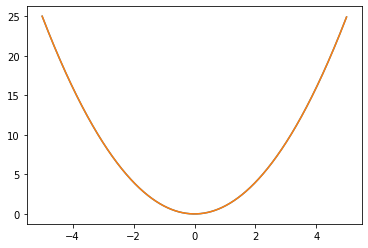

In [772]:
main()